<a href="https://colab.research.google.com/github/claytoncohn/CoralBleaching_SkinCancer/blob/master/CSC594_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clayton Cohn<br>
CSC594<br>
Prof. Noriko Tomuro<br>
16 Sep 2020<br>

## <center>CSC594: Assignment 1 </center>

*The starter code for this assignment was provided by Prof. Noriko Tomuro, and can be found at: https://condor.depaul.edu/ntomuro/courses/594ADL-2020fall/assign/hw1files/CSC594-HW1-startup.pdf*

In [1]:
## Code piece to mount my Google Drive
from google.colab import drive 
drive.mount("/content/drive") # my Google root directory will be mapped here

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Change the working directory to the work directory (where the code file is).
import os
os.chdir('/content/drive/My Drive/CSC594')

# Ensure the files are there (in the folder)
!pwd
!ls -l

/content/drive/My Drive/CSC594
total 494
-rw------- 1 root root  15502 Sep 22 18:22 ccAssignment1.csv
-rw------- 1 root root 489895 Sep 22 18:23 CSC594_Assignment1.ipynb


Start of the code

In [3]:
pip install -q tfds-nightly tensorflow matplotlib

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [5]:
# First load the datasets.
# The original dataset has two partitions ('train' and 'test').
# For our purpose, the 'train' set is split into training (80%) and validation (20%).

(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    'rock_paper_scissors', # 'svhn_cropped',# 
    split=['train[:80%]', 'train[80%:]', 'test'],
    shuffle_files=False, # because we don't want to shuffle testdata
    as_supervised=True,
    with_info=True,
)
print (ds_info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)



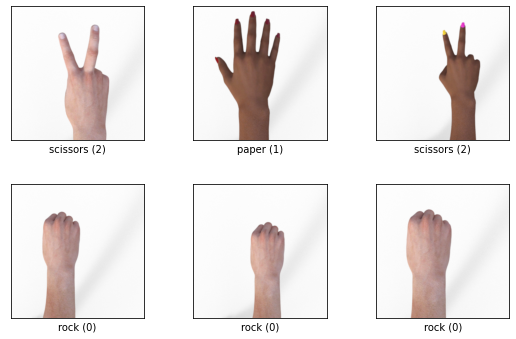

In [6]:
# Test by visualizing some images.
ds2 = ds_test.take(6)
fig = tfds.show_examples(ds2, ds_info)

In [7]:
# Obtain total number of target classes, class names and 
# image shape from ds_info.
num_classes = ds_info.features["label"].num_classes
print (num_classes)
classnames = ds_info.features["label"].names
print (classnames)
classlabel = ds_info.features["label"]
intlabels = [classlabel.str2int(cname) for cname in classnames]
print (intlabels)
image_shape = ds_info.features['image'].shape
print (image_shape)

3
['rock', 'paper', 'scissors']
[0, 1, 2]
(300, 300, 3)


In [8]:
# Check the number of examples in each dataset to ensure the data split/loading worked.
train_size = tf.data.experimental.cardinality(ds_train)
valid_size = tf.data.experimental.cardinality(ds_valid)
test_size = tf.data.experimental.cardinality(ds_test)
print ('train: %d, valid: %d, test: %d' % (train_size, valid_size, test_size))
# should be train: 2016, valid: 504, test: 372

train: 2016, valid: 504, test: 372


In [9]:
# Reshape the images to (299, 299) (to be compatible with InceptionNet)
size = (299, 299)

ds_train = ds_train.map(lambda x, y: (tf.image.resize(x, size), y))
ds_valid = ds_valid.map(lambda x, y: (tf.image.resize(x, size), y))
ds_test = ds_test.map(lambda x, y: (tf.image.resize(x, size), y))

print(ds_test.take(1))

<TakeDataset shapes: ((299, 299, 3), ()), types: (tf.float32, tf.int64)>


In [10]:
# Normalize the pixel value of images to [0,1].
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# training set -- normalize, shuffle and set batch size
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(train_size) #ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

# validation set -- normalize, shuffle and set batch size
ds_valid = ds_valid.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_valid = ds_valid.cache()
ds_valid = ds_valid.shuffle(valid_size) #ds_info.splits['train'].num_examples)
ds_valid = ds_valid.batch(128)
ds_valid = ds_valid.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
# test set -- normalize and set batch size, but NO SHUFFLING
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

I chose 5 pretrained models from the Keras docs based on best listed accuracies:


1.   VGG19
2.   ResNet152V2
3.   Xception
4.   InceptionResNetV2
5.   NASNetLarge

In [12]:
# Starting with VGG19

# Code taken from link provided by Prof. Tomuro: https://www.kaggle.com/janvichokshi/transfer-learning-cnn-resnet-vgg16-iceptionv3

image_shape = (299, 299, 3)

def getVGG(w):
  vgg19 = tf.keras.applications.VGG19(input_shape = image_shape,
                        include_top = False, 
                        weights = 'imagenet' if w else None)


  # Freeze layers
  for layer in vgg19.layers:
      layer.trainable = False

  vgg19.summary()

  # Build off of last layer

  last_layer = vgg19.get_layer('block5_pool')
  print('last layer of vgg : output shape: ', last_layer.output_shape)
  last_output= last_layer.output

  x = tf.keras.layers.Flatten()(last_output)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)                  
  x = tf.keras.layers.Dense(3, activation='softmax')(x)           

  vgg19 = tf.keras.Model(vgg19.input, x) 
  return vgg19

In [13]:
# Will start with random weights

vgg19 = getVGG(False)
vgg19.compile(
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [14]:
vgg19.fit(
    ds_train,
    epochs=5,
    validation_data=ds_valid)

Epoch 1/5
16/16 [==============================] - 11s 668ms/step - loss: 1.0976 - acc: 0.3581 - val_loss: 1.0956 - val_acc: 0.5298
Epoch 2/5
16/16 [==============================] - 7s 419ms/step - loss: 1.0949 - acc: 0.4469 - val_loss: 1.0935 - val_acc: 0.6409
Epoch 3/5
16/16 [==============================] - 7s 420ms/step - loss: 1.0929 - acc: 0.4405 - val_loss: 1.0914 - val_acc: 0.4643
Epoch 4/5
16/16 [==============================] - 7s 418ms/step - loss: 1.0911 - acc: 0.4891 - val_loss: 1.0893 - val_acc: 0.6488
Epoch 5/5
16/16 [==============================] - 7s 421ms/step - loss: 1.0887 - acc: 0.5660 - val_loss: 1.0879 - val_acc: 0.4385


5 epochs with randomly initialized weights was unsurprisingly not very effective. Now we will try it with the ImageNet weights.

In [15]:
vgg19 = getVGG(True)
vgg19.compile(
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [16]:
vgg19.fit(
    ds_train,
    epochs=5,
    validation_data=ds_valid)

Epoch 1/5
16/16 [==============================] - 7s 434ms/step - loss: 1.9665 - acc: 0.6999 - val_loss: 0.0611 - val_acc: 0.9940
Epoch 2/5
16/16 [==============================] - 7s 424ms/step - loss: 0.0438 - acc: 0.9970 - val_loss: 0.0217 - val_acc: 1.0000
Epoch 3/5
16/16 [==============================] - 7s 424ms/step - loss: 0.4879 - acc: 0.9008 - val_loss: 0.0098 - val_acc: 1.0000
Epoch 4/5
16/16 [==============================] - 7s 424ms/step - loss: 0.0098 - acc: 0.9995 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 5/5
16/16 [==============================] - 7s 424ms/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000


Got 100% accuracy within a couple of iterations so almost certainly overfitting. Let's evaluate test set to confirm this.

In [17]:
vgg19.evaluate(ds_test)

3/3 [==============================] - 2s 727ms/step - loss: 0.3666 - acc: 0.8118


[0.36658838391304016, 0.8118279576301575]

Let's try data augmentation to see if we can improve upon this. We will extract and save all images locally and then import them for augmentation. Code is taken from TensorFlow docs: https://www.tensorflow.org/tutorials/images/data_augmentation.

In [18]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:]', 'test'],
    shuffle_files = False,
    with_info=True,
    as_supervised=True,
)

# Check the number of examples in each dataset to ensure the data split/loading worked.
train_size = tf.data.experimental.cardinality(train_ds)
valid_size = tf.data.experimental.cardinality(val_ds)
test_size = tf.data.experimental.cardinality(test_ds)
print ('train: %d, valid: %d, test: %d' % (train_size, valid_size, test_size))
# should be train: 2016, valid: 504, test: 372

train: 2016, valid: 504, test: 372


In [19]:
IMG_SIZE = 299

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [21]:
ds_aug = prepare(train_ds, shuffle=True, augment=True)
ds_val = prepare(val_ds)
ds_test = prepare(test_ds)

In [22]:
vgg19 = getVGG(True)
vgg19.compile(
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [23]:
vgg19.fit(
    ds_aug,
    epochs=5,
    validation_data=ds_val)

Epoch 1/5
63/63 [==============================] - 13s 213ms/step - loss: 1.3846 - acc: 0.6195 - val_loss: 0.2615 - val_acc: 0.9385
Epoch 2/5
63/63 [==============================] - 13s 213ms/step - loss: 0.3722 - acc: 0.8502 - val_loss: 0.1557 - val_acc: 0.9603
Epoch 3/5
63/63 [==============================] - 13s 210ms/step - loss: 0.2118 - acc: 0.9241 - val_loss: 0.0413 - val_acc: 0.9960
Epoch 4/5
63/63 [==============================] - 13s 212ms/step - loss: 0.1520 - acc: 0.9420 - val_loss: 0.5790 - val_acc: 0.7044
Epoch 5/5
63/63 [==============================] - 13s 213ms/step - loss: 0.1263 - acc: 0.9544 - val_loss: 0.0355 - val_acc: 0.9940


In [24]:
vgg19.evaluate(ds_test)

12/12 [==============================] - 1s 111ms/step - loss: 0.4677 - acc: 0.8683


[0.4676513373851776, 0.8682795763015747]

Augmentation helped considerably, so now we will use the augmented dataset going forward.

Now let's implement ResNet 152V2

In [25]:
resnet = tf.keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape
)

# Freeze layers
for layer in resnet.layers:
  layer.trainable = False

resnet.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [26]:
  # Build off of last layer

  last_layer = resnet.get_layer('conv5_block3_out')
  print('last layer of resnet : output shape: ', last_layer.output_shape)
  last_output= last_layer.output

  x = tf.keras.layers.Flatten()(last_output)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)                  
  x = tf.keras.layers.Dense(3, activation='softmax')(x)           

  resnet = tf.keras.Model(resnet.input, x) 

last layer of resnet : output shape:  (None, 10, 10, 2048)


In [27]:
resnet.compile(
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [28]:
resnet.fit(
    ds_aug,
    epochs=5,
    validation_data=ds_val)

Epoch 1/5
63/63 [==============================] - 18s 287ms/step - loss: 7.2959 - acc: 0.4365 - val_loss: 0.9022 - val_acc: 0.6230
Epoch 2/5
63/63 [==============================] - 15s 239ms/step - loss: 1.1385 - acc: 0.6042 - val_loss: 0.5571 - val_acc: 0.7560
Epoch 3/5
63/63 [==============================] - 15s 243ms/step - loss: 0.7059 - acc: 0.6895 - val_loss: 0.5283 - val_acc: 0.8373
Epoch 4/5
63/63 [==============================] - 15s 243ms/step - loss: 0.5457 - acc: 0.7847 - val_loss: 0.4049 - val_acc: 0.9504
Epoch 5/5
63/63 [==============================] - 15s 243ms/step - loss: 0.4761 - acc: 0.8180 - val_loss: 0.5600 - val_acc: 0.6825


In [29]:
resnet.evaluate(ds_test)

12/12 [==============================] - 2s 135ms/step - loss: 0.7420 - acc: 0.5618


[0.741994321346283, 0.5618279576301575]

Now let's try Xception.

In [30]:
xception = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape
)

# Freeze layers
for layer in xception.layers:
  layer.trainable = False

xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [31]:
  # Build off of last layer

  last_layer = xception.get_layer('block14_sepconv2_act')
  print('last layer of xception : output shape: ', last_layer.output_shape)
  last_output= last_layer.output

  x = tf.keras.layers.Flatten()(last_output)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)                  
  x = tf.keras.layers.Dense(3, activation='softmax')(x)           

  xception = tf.keras.Model(xception.input, x) 

last layer of xception : output shape:  (None, 10, 10, 2048)


In [32]:
xception.compile(
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [33]:
xception.fit(
    ds_aug,
    epochs=5,
    validation_data=ds_val)

Epoch 1/5
63/63 [==============================] - 14s 220ms/step - loss: 1.6296 - acc: 0.7440 - val_loss: 0.3297 - val_acc: 0.8869
Epoch 2/5
63/63 [==============================] - 13s 210ms/step - loss: 0.1457 - acc: 0.9529 - val_loss: 0.0697 - val_acc: 0.9722
Epoch 3/5
63/63 [==============================] - 13s 212ms/step - loss: 0.1059 - acc: 0.9638 - val_loss: 0.1012 - val_acc: 0.9623
Epoch 4/5
63/63 [==============================] - 13s 210ms/step - loss: 0.0699 - acc: 0.9707 - val_loss: 0.0358 - val_acc: 0.9821
Epoch 5/5
63/63 [==============================] - 13s 214ms/step - loss: 0.0591 - acc: 0.9787 - val_loss: 0.3362 - val_acc: 0.8750


In [34]:
xception.evaluate(ds_test)

12/12 [==============================] - 1s 80ms/step - loss: 1.0382 - acc: 0.7097


[1.0382057428359985, 0.7096773982048035]

Now let's try InceptionResNetV2.

In [35]:
inception_resnet = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape
)

# Freeze layers
for layer in inception_resnet.layers:
  layer.trainable = False

inception_resnet.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 149, 149, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_4[0][0]      
________________________________________________________________________________

In [36]:
  # Build off of last layer

  last_layer = inception_resnet.get_layer('conv_7b_ac')
  print('last layer of inception_resnet : output shape: ', last_layer.output_shape)
  last_output= last_layer.output

  x = tf.keras.layers.Flatten()(last_output)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)                  
  x = tf.keras.layers.Dense(3, activation='softmax')(x)           

  inception_resnet = tf.keras.Model(inception_resnet.input, x) 

last layer of inception_resnet : output shape:  (None, 8, 8, 1536)


In [37]:
inception_resnet.compile(
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [38]:
inception_resnet.fit(
    ds_aug,
    epochs=2,
    validation_data=ds_val)

Epoch 1/2
63/63 [==============================] - 17s 270ms/step - loss: 2.6106 - acc: 0.6954 - val_loss: 0.2808 - val_acc: 0.9008
Epoch 2/2
63/63 [==============================] - 14s 227ms/step - loss: 0.1427 - acc: 0.9420 - val_loss: 0.3296 - val_acc: 0.8750


In [39]:
inception_resnet.evaluate(ds_test)

12/12 [==============================] - 2s 125ms/step - loss: 1.8602 - acc: 0.6102


[1.8602406978607178, 0.6102150678634644]

Since VGG19 gave the best performance, we will fine-tune that one.

In [40]:
vgg19 = tf.keras.applications.VGG19(input_shape = image_shape,
                        include_top = False, 
                        weights = 'imagenet')

# Freeze layers
for layer in vgg19.layers:
    layer.trainable = False

# Build off of last layer

last_layer = vgg19.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output= last_layer.output

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)                  
x = tf.keras.layers.Dense(3, activation='softmax')(x)           

vgg19 = tf.keras.Model(vgg19.input, x) 

vgg19.summary()

last layer of vgg : output shape:  (None, 9, 9, 512)
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________


Let's unfreeze the last block.

In [41]:
l = vgg19.get_layer('block5_conv1')
l.trainable = True

l = vgg19.get_layer('block5_conv2')
l.trainable = True

l = vgg19.get_layer('block5_conv3')
l.trainable = True

l = vgg19.get_layer('block5_conv4')
l.trainable = True

l = vgg19.get_layer('block5_pool')
l.trainable = True

Confirm that last convolutional block and on is trainable.

In [42]:
for layer in vgg19.layers:
  frozen = layer.trainable
  print(layer.name, "trainable: ", frozen)

input_7 trainable:  False
block1_conv1 trainable:  False
block1_conv2 trainable:  False
block1_pool trainable:  False
block2_conv1 trainable:  False
block2_conv2 trainable:  False
block2_pool trainable:  False
block3_conv1 trainable:  False
block3_conv2 trainable:  False
block3_conv3 trainable:  False
block3_conv4 trainable:  False
block3_pool trainable:  False
block4_conv1 trainable:  False
block4_conv2 trainable:  False
block4_conv3 trainable:  False
block4_conv4 trainable:  False
block4_pool trainable:  False
block5_conv1 trainable:  True
block5_conv2 trainable:  True
block5_conv3 trainable:  True
block5_conv4 trainable:  True
block5_pool trainable:  True
flatten_6 trainable:  True
dense_12 trainable:  True
dropout_6 trainable:  True
dense_13 trainable:  True


In [43]:
# Lower the learning rate

vgg19.compile(
              optimizer = tf.keras.optimizers.RMSprop(lr=0.00001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [44]:
vgg19.fit(
    ds_aug,
    epochs=5,
    validation_data=ds_val)

Epoch 1/5
63/63 [==============================] - 14s 220ms/step - loss: 0.5231 - acc: 0.8001 - val_loss: 0.0939 - val_acc: 0.9940
Epoch 2/5
63/63 [==============================] - 14s 217ms/step - loss: 0.0623 - acc: 0.9851 - val_loss: 0.0297 - val_acc: 0.9940
Epoch 3/5
63/63 [==============================] - 14s 215ms/step - loss: 0.0250 - acc: 0.9931 - val_loss: 0.0161 - val_acc: 0.9980
Epoch 4/5
63/63 [==============================] - 14s 217ms/step - loss: 0.0172 - acc: 0.9960 - val_loss: 0.0063 - val_acc: 0.9980
Epoch 5/5
63/63 [==============================] - 14s 220ms/step - loss: 0.0054 - acc: 0.9990 - val_loss: 0.0301 - val_acc: 0.9802


In [45]:
vgg19.evaluate(ds_test)

12/12 [==============================] - 1s 77ms/step - loss: 0.4585 - acc: 0.8522


[0.4584939181804657, 0.852150559425354]

Save predictions to .csv file.

In [46]:
import csv

predictions = vgg19.predict(ds_test)
i = 1
with open('ccAssignment1.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id", "cat0", "cat1", "cat2"])

    for item in predictions:
      writer.writerow([i, item[0], item[1], item[2]])
      i+=1

The next part of the assignment is to visualize the feature maps and filters. For this we must train the model from scratch, so we will instantiate (and train) a new CNN model with randomly initialized weights.

I will use VGG19 for this as well.

Let's start with the feature maps.

The code for implementing feature maps was taken from the link provided from Prof. Tomuro, courtesy of Francois Chollet: https://condor.depaul.edu/ntomuro/courses/594ADL-2020fall/Chollet/Chollet-v1-convvis.pdf

In [47]:
vgg19 = tf.keras.applications.VGG19(input_shape = image_shape,
                        include_top = False, 
                        weights = None)

# Freeze layers
for layer in vgg19.layers:
    layer.trainable = True

# Build off of last layer

last_layer = vgg19.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output= last_layer.output

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)                  
x = tf.keras.layers.Dense(3, activation='softmax')(x)           

vgg19 = tf.keras.Model(vgg19.input, x) 

vgg19.summary()

last layer of vgg : output shape:  (None, 9, 9, 512)
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________


In [53]:
vgg19.compile(
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [64]:
vgg19.fit(
    ds_aug,
    epochs=1,
    validation_data=ds_val)

 2/63 [..............................] - ETA: 18s - loss: 0.3281 - acc: 0.8750WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1380s vs `on_train_batch_end` time: 0.2110s). Check your callbacks.


63/63 [==============================] - 22s 356ms/step - loss: 0.1693 - acc: 0.9375 - val_loss: 0.0894 - val_acc: 0.9802


Now that the model has been trained from scratch, we can take a look at the feature maps.

In [65]:
from keras import models
layer_outputs = [layer.output for layer in vgg19.layers[:8]]
activation_model = models.Model(inputs=vgg19.input, outputs=layer_outputs)

In [70]:
activations = activation_model.predict(ds_aug.take(1))
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(32, 299, 299, 3)


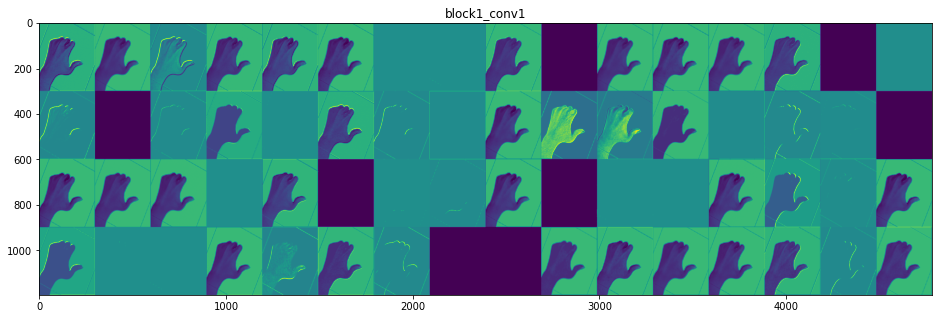

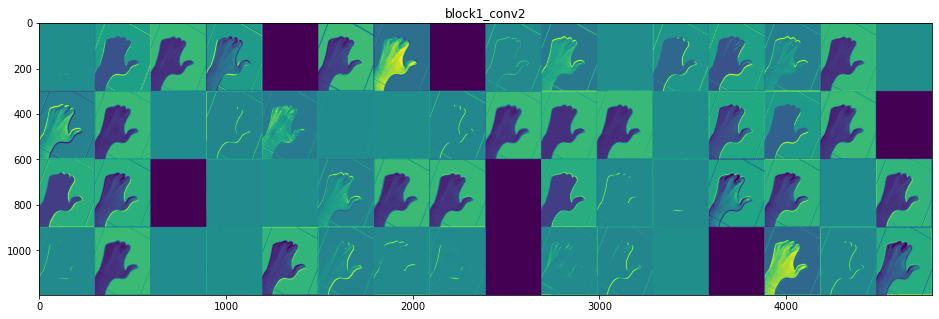

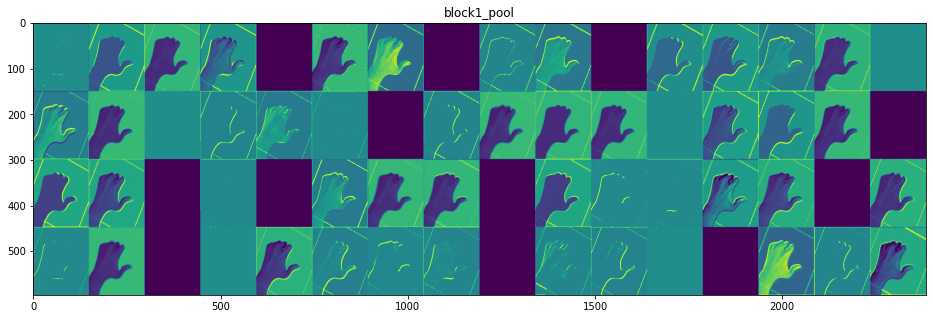

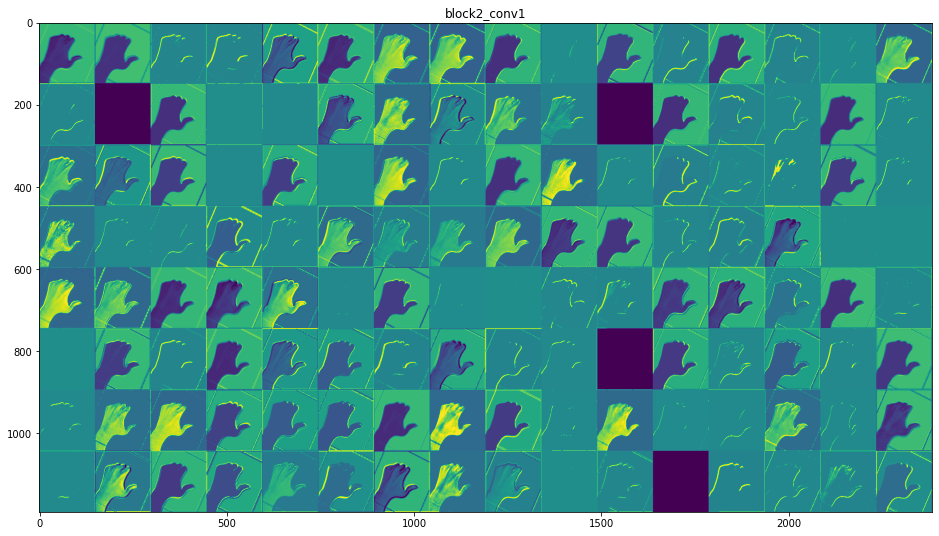

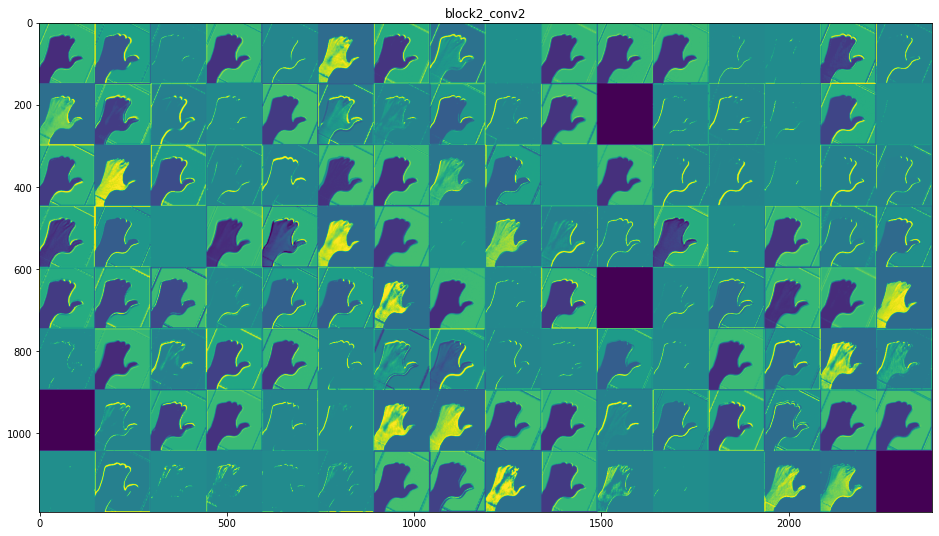

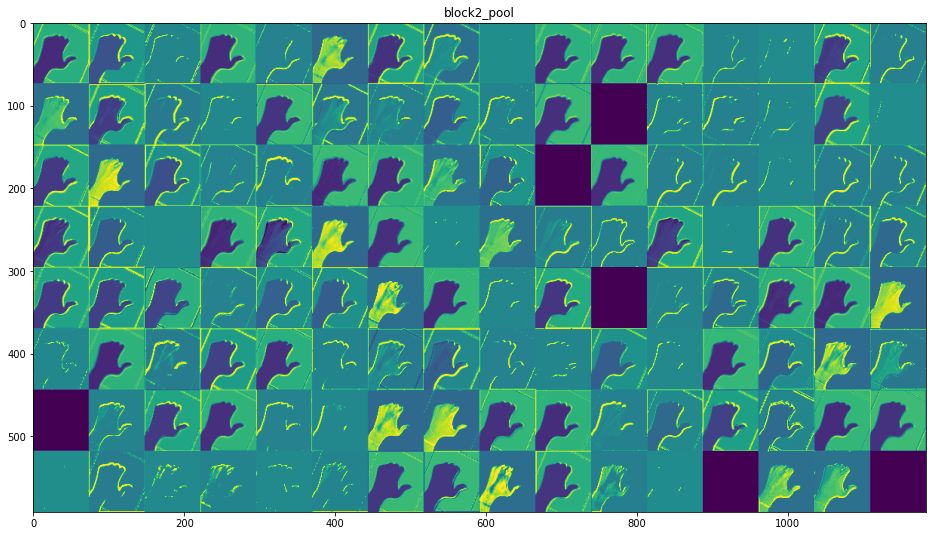

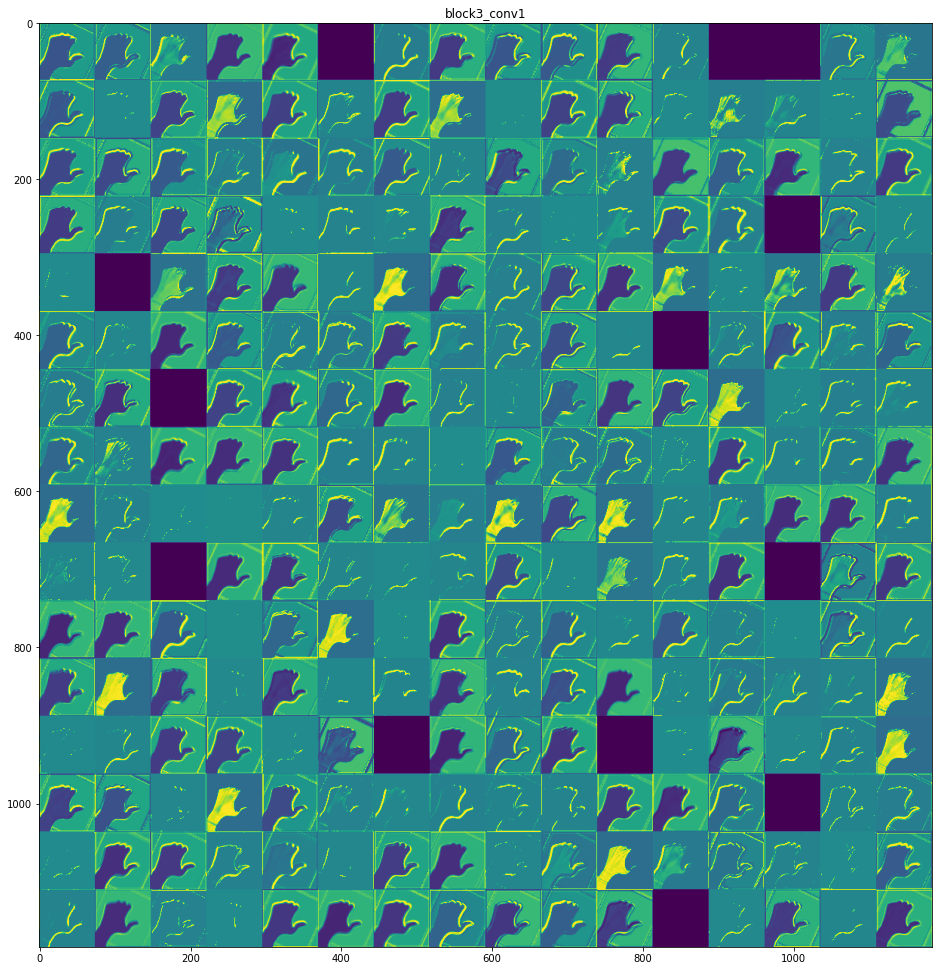

In [83]:
layer_names = []
for layer in vgg19.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  if layer_name == "input_8": continue
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,:, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image


  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0] + 1))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

Now it's time to visualizer the filters.